<a href="https://colab.research.google.com/github/Sr123Saha/3_intensiv_3/blob/test/savva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [52]:

# Загрузка данных
train_df = pd.read_excel("train.xlsx")
#test_df = pd.read_excel("test.xlsx")


In [53]:

# Преобразование даты
train_df["dt"] = pd.to_datetime(train_df["dt"])
#test_df["dt"] = pd.to_datetime(test_df["dt"])


In [54]:

# Создание новых признаков
def create_features(df):
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["week"] = df["dt"].dt.isocalendar().week
    df["dayofyear"] = df["dt"].dt.dayofyear
    df["quarter"] = df["dt"].dt.quarter
    for lag in range(1, 6):
        df[f"lag_{lag}"] = df["Цена на арматуру"].shift(lag)
    df["rolling_mean_3"] = df["Цена на арматуру"].rolling(window=3).mean()
    df["rolling_mean_6"] = df["Цена на арматуру"].rolling(window=6).mean()
    df["diff_1"] = df["Цена на арматуру"].diff(1)
    df["diff_2"] = df["Цена на арматуру"].diff(2)
    df["log_price"] = np.log1p(df["Цена на арматуру"])
    return df

train_df = create_features(train_df).dropna()

In [42]:

# Разделение данных на обучающую и тестовую выборку
X = train_df.drop(columns=["dt", "Цена на арматуру"])
y = train_df["Цена на арматуру"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [43]:

# Определение моделей и их параметров
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

param_grids = {
    "RandomForest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3]
    },
    "GradientBoosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    }
}

best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"{name} лучшие параметры: {grid_search.best_params_}")

RandomForest лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoosting лучшие параметры: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
XGBoost лучшие параметры: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [44]:

# Оценка моделей
for name, model in best_models.items():
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"{name} -> MAE: {mae}, R2: {r2}")

RandomForest -> MAE: 5082.658227848101, R2: 0.45721454071626566
GradientBoosting -> MAE: 4316.977357679152, R2: 0.598768331341932
XGBoost -> MAE: 4352.40087890625, R2: 0.5966479778289795


In [45]:


# Обучение на всем трейне и предсказание на тестовом файле
test_df = create_features(test_df).dropna()
X_test = test_df.drop(columns=["dt", "Цена на арматуру"], errors='ignore')

for name, model in best_models.items():
    model.fit(X, y)  # дообучаем на всей выборке
    test_df[f"Прогноз_{name}"] = model.predict(X_test)

In [46]:

# Сохранение предсказаний в файл
test_df.to_excel("predictions.xlsx", index=False)


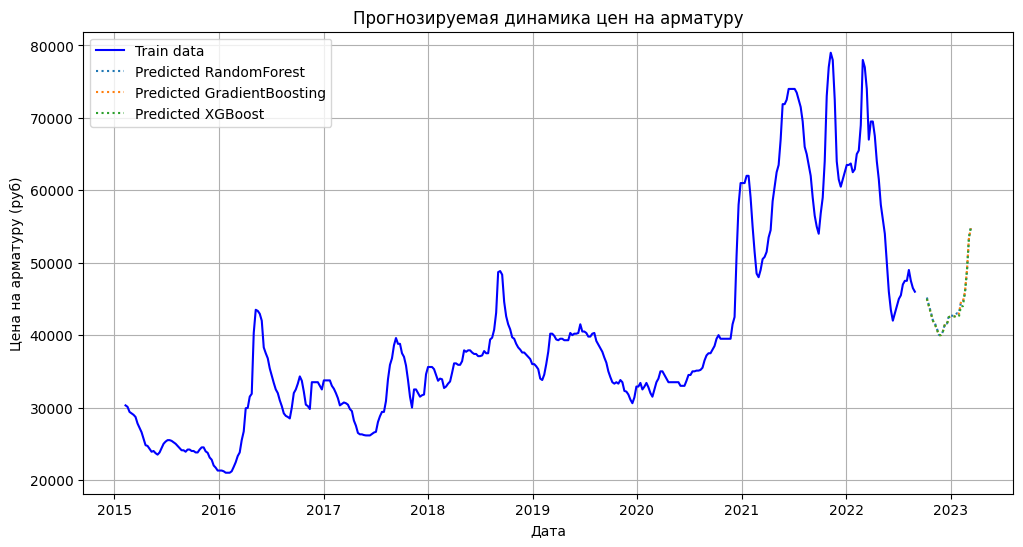

In [47]:



# Графики
plt.figure(figsize=(12, 6))
plt.plot(train_df["dt"], train_df["Цена на арматуру"], label="Train data", color='blue')
for name in best_models.keys():
    plt.plot(test_df["dt"], test_df[f"Прогноз_{name}"], label=f"Predicted {name}", linestyle='dotted')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру (руб)")
plt.title("Прогнозируемая динамика цен на арматуру")
plt.legend()
plt.grid()
plt.show()

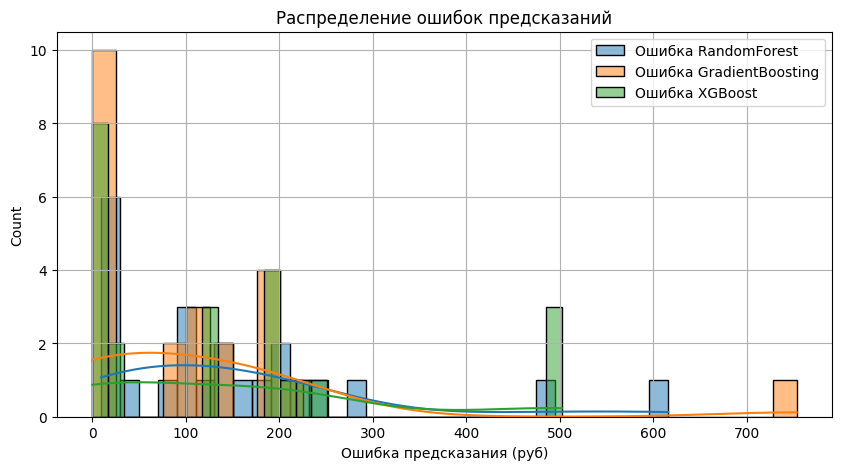

In [48]:
# Гистограмма ошибок
plt.figure(figsize=(10, 5))
for name in best_models.keys():
    sns.histplot(abs(test_df["Цена на арматуру"] - test_df[f"Прогноз_{name}"]), bins=30, kde=True, label=f"Ошибка {name}")
plt.xlabel("Ошибка предсказания (руб)")
plt.title("Распределение ошибок предсказаний")
plt.legend()
plt.grid()
plt.show()

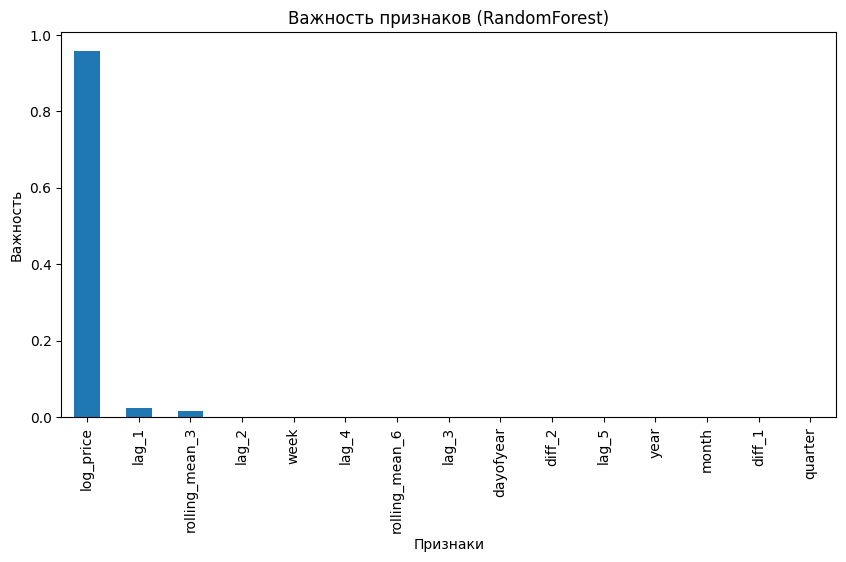

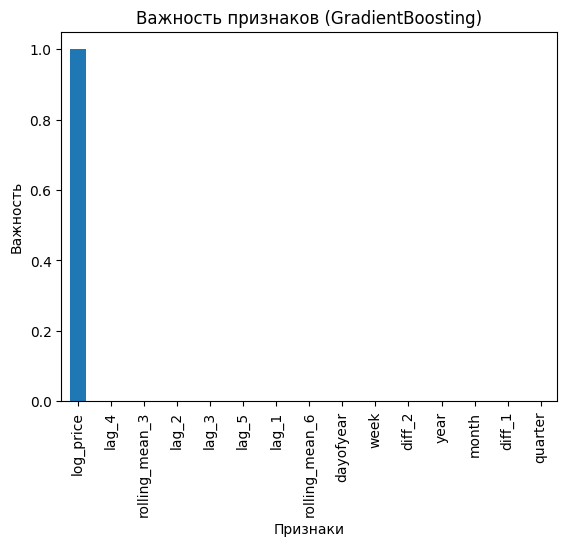

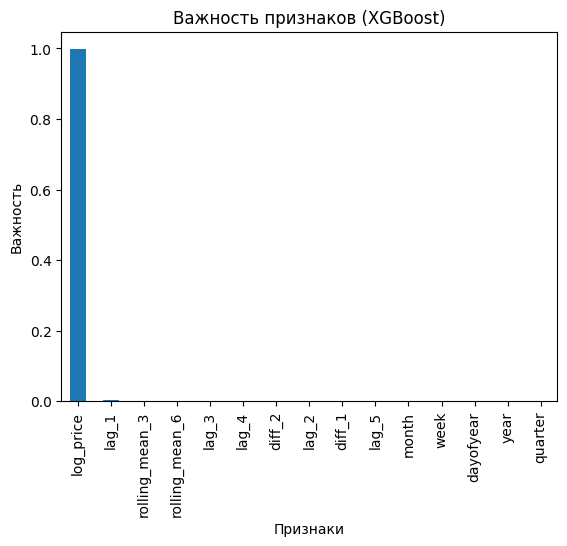

In [49]:

# Важность признаков
plt.figure(figsize=(10, 5))
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
        importance.plot(kind='bar', title=f"Важность признаков ({name})")
        plt.xlabel("Признаки")
        plt.ylabel("Важность")
        plt.show()


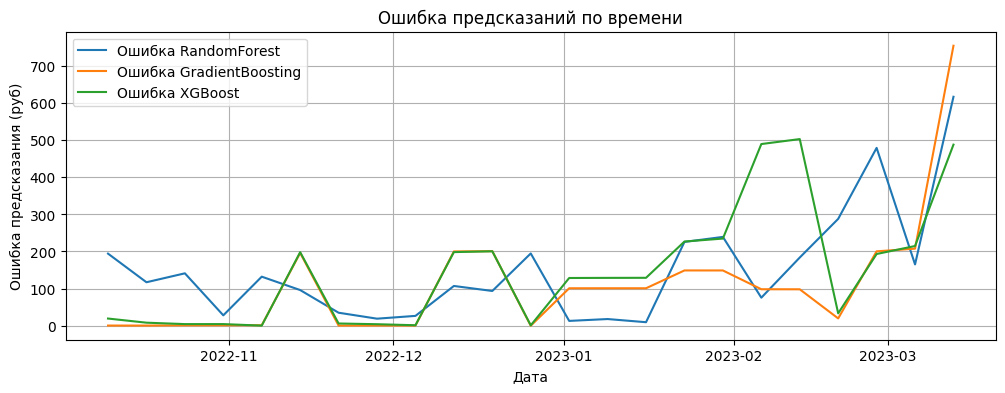

In [50]:

# График ошибок
plt.figure(figsize=(12, 4))
for name in best_models.keys():
    plt.plot(test_df["dt"], abs(test_df["Цена на арматуру"] - test_df[f"Прогноз_{name}"]), label=f"Ошибка {name}")
plt.xlabel("Дата")
plt.ylabel("Ошибка предсказания (руб)")
plt.title("Ошибка предсказаний по времени")
plt.legend()
plt.grid()
plt.show()